In [1]:
''' This script trains a score-based model to learn a score function with the built-in singularity.'''

## Importing necessary libraries
import torch, random, shutil, os, numpy as np, torch.nn as nn
import matplotlib.pyplot as plt
from ema_pytorch import EMA

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting up the plotting parameters
plt.rcParams.update({"text.usetex": True,"font.family": "sans-serif",'font.size': 18})

## Load data

<Figure size 200x200 with 0 Axes>

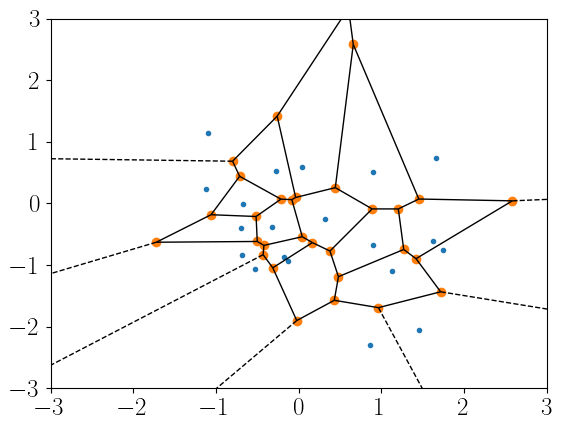

In [2]:
# Set seed manually for reproducibility
random.seed(1)
np.random.seed(1)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load data
data = torch.from_numpy(np.load("training_data.npy")).float()
N = data.shape[0]
dim = data.shape[1]

# plot data
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(data)
plt.figure(figsize=(2,2))
fig = voronoi_plot_2d(vor)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

## Define model

In [10]:
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class score_edm(torch.nn.Module):
    '''
        Neural network to learn the score function
        Results in the paper use the default settings of width=256, depth=2, activation=ReLU
    '''
    def __init__(self, device, width=256, depth=2, embed_dim=8, activation=nn.ReLU, schedule=None):
        super().__init__()
        
        self.width = width
        self.depth = depth
        self.activation = activation()
        self.embed = GaussianFourierProjection(embed_dim, scale=1.0)
        net = []
        net.append(nn.Linear(2+embed_dim,self.width))
        net.append(self.activation)
        for _ in range(self.depth):
            net.append(nn.Linear(self.width,self.width))
            net.append(self.activation)
        net.append(nn.Linear(self.width,2))
        self.net = nn.Sequential(*net).to(device=device)
        
    def forward(self, x, t):
        embed = self.embed(t.squeeze())
        x_in = torch.cat([x, embed], dim=-1)
        score = self.net(x_in).to(torch.float32)
        return score
    
def loss_func(net, X, schedule, reg_strength=0.0):
    ''' Denoising score matching loss function (un-regularized)
    '''
    t = torch.rand([X.shape[0], 1], device=X.device)
    noise = torch.randn_like(X) 
    mean = (schedule.marginal_prob_mean(t)).to(X.device)
    std  = (schedule.marginal_prob_std(t)).to(X.device)
    x_tilde = mean * X + std * noise
    score = net(x_tilde, t)
    # compute reg constant
    reg_lambda = reg_strength 
    # evaluate loss with regularization term
    loss = torch.mean((std*score + noise)**2, dim=(1)) + reg_lambda*torch.mean(score**2, dim=(1))
    return loss.mean()

from score_models import GMM_score, VE, VP

# Training parameters
n_epochs        = 200000 # maximum number of total epochs
lr              = 1e-3   # learning rate
width           = 256    # Width of the score network 
depth           = 2      # Depth of the score network
plot_every      = 5000   # Plotting interval
embed_dim       = 8      # Dimension of the time embedding
path_to_save    = './experiments/Tikhonov/'
figures_path    = './figures/VP_NN_Tikhonov/'

# define schedule
schedule = VP()
#schedule = VE()

# define reg strengths
reg_strength_vect = [0.0001,0.001,0.01,0.1]

## Train network

In [11]:
# define path for saving model
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

for reg_strength in reg_strength_vect:
    print(reg_strength)
    
    # Define network
    score_net = score_edm(device=device, width=width, depth=depth, embed_dim=embed_dim, activation=nn.ReLU)
    score_ema = EMA(score_net, beta=0.9999)

    # define optimizer
    optimizer = torch.optim.Adam(score_net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    # Training loop
    for epoch in range(n_epochs):
        score_net.train()

        # shuffle data
        X = data.to(device) 
        X = X[torch.randperm(X.shape[0])]

        # evaluate loss and backpropagate
        loss = loss_func(score_net, X, schedule, reg_strength=reg_strength)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        score_ema.update()
            
        # save results
        if (epoch+1) % plot_every == 0:
            print("epoch: {}, loss: {}".format(epoch, loss.item()))
            states = [score_net.state_dict(),score_ema.state_dict(),optimizer.state_dict()]
            torch.save(states, path_to_save+'regstrength'+str(reg_strength)+'_checkpoint_'+str(epoch)+'.pth')


0.0001
epoch: 4999, loss: 0.5034012198448181
epoch: 9999, loss: 0.51744544506073
epoch: 14999, loss: 0.7856189608573914
epoch: 19999, loss: 0.6053376793861389
epoch: 24999, loss: 0.4812498092651367
epoch: 29999, loss: 0.5330641269683838
epoch: 34999, loss: 0.35397571325302124
epoch: 39999, loss: 0.5997134447097778
epoch: 44999, loss: 0.24498090147972107
epoch: 49999, loss: 0.649964451789856
epoch: 54999, loss: 0.48308905959129333
epoch: 59999, loss: 0.2915264964103699
epoch: 64999, loss: 0.3431706726551056
epoch: 69999, loss: 0.30967456102371216
epoch: 74999, loss: 0.45606088638305664
epoch: 79999, loss: 0.5653196573257446
epoch: 84999, loss: 0.6024453043937683
epoch: 89999, loss: 0.22597560286521912
epoch: 94999, loss: 0.3099941611289978
epoch: 99999, loss: 0.6127912998199463
epoch: 104999, loss: 0.23499509692192078
epoch: 109999, loss: 0.6942017078399658
epoch: 114999, loss: 0.2643139958381653
epoch: 119999, loss: 0.4481070041656494
epoch: 124999, loss: 0.46509504318237305
epoch: 129

## Plot generated samples

/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_29598/4193091212.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res_loc = torch.tensor(samples_x, device=latents.device, dtype=torch.float32).reshape(lat_shape)


<Figure size 640x480 with 0 Axes>

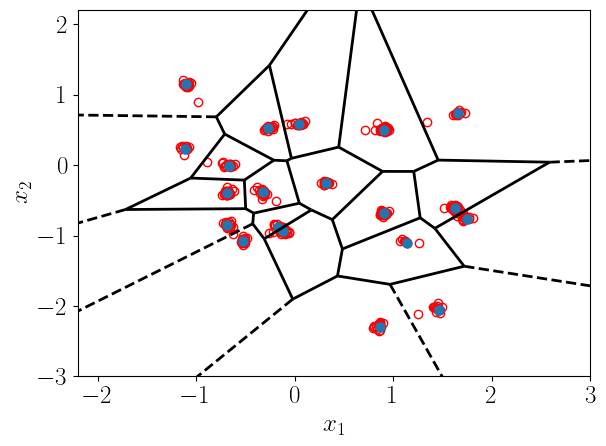

<Figure size 640x480 with 0 Axes>

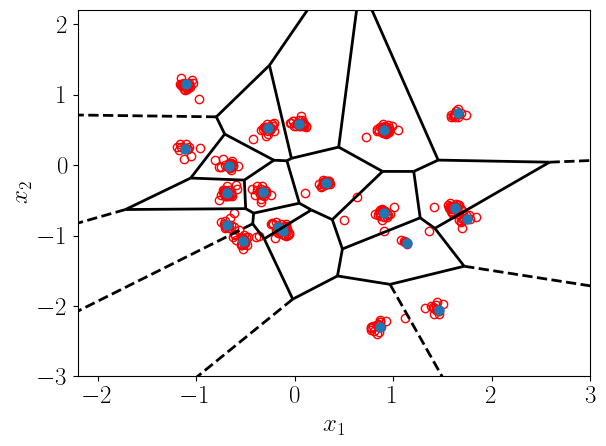

<Figure size 640x480 with 0 Axes>

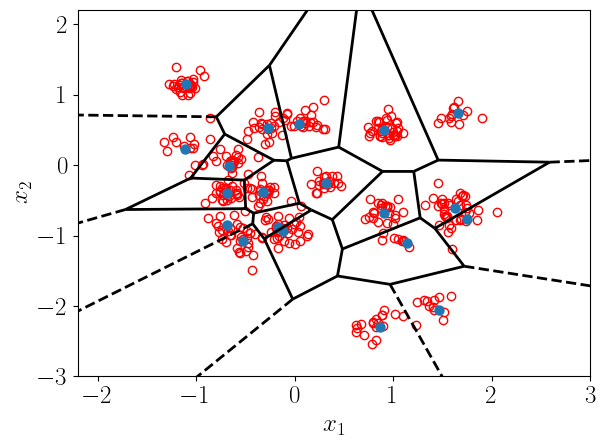

<Figure size 640x480 with 0 Axes>

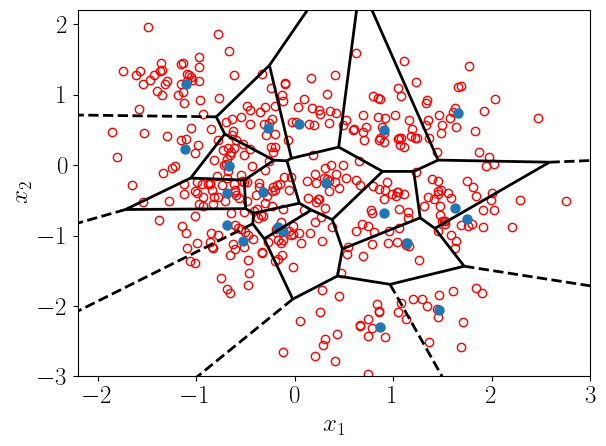

In [16]:
# define latents for sampling and integrate model
batch_size = 1000
latents = torch.randn(batch_size, dim)

# define points for plotting
plotting_pts = 400

# epoch for plotting
epoch = n_epochs-1

# Define network
score_net = score_edm(device=device, width=width, depth=depth, embed_dim=embed_dim, activation=nn.ReLU)
score_ema = EMA(score_net, beta=0.9999)

for (kk,reg_strength) in enumerate(reg_strength_vect):
    # load model
    score_ema.load_state_dict(torch.load(path_to_save+'regstrength'+str(reg_strength)+'_checkpoint_'+str(epoch)+'.pth')[1])
    # integrate model
    samples_t, samples_x = schedule.ODEsampler(score_ema, latents, T0=1.0, T1=0.)
    # extract final samples
    lat_shape = [batch_size, 2, len(samples_t)]
    res_loc = torch.tensor(samples_x, device=latents.device, dtype=torch.float32).reshape(lat_shape)
    final_samples = res_loc[:,:,-1]
    # plot generated samples
    plt.figure()
    fig = voronoi_plot_2d(vor, show_vertices=False, line_width=2, point_size=13)
    plt.plot(final_samples[:plotting_pts,0], final_samples[:plotting_pts,1], 'or', mfc='none', zorder=0)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xlim(-2.2,3)
    plt.ylim(-3,2.2)
    plt.tight_layout()
    plt.savefig(figures_path+'regstrength'+str(reg_strength)+'.pdf')

## Plot fraction of points collapsed onto data

/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_29598/3059696220.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res_loc = torch.tensor(samples_x, device=latents.device, dtype=torch.float32).reshape(lat_shape)
/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_29598/3059696220.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist = torch.sqrt(torch.sum((final_samples[i,:] - torch.tensor(data, dtype=torch.float32))**2, axis=1))


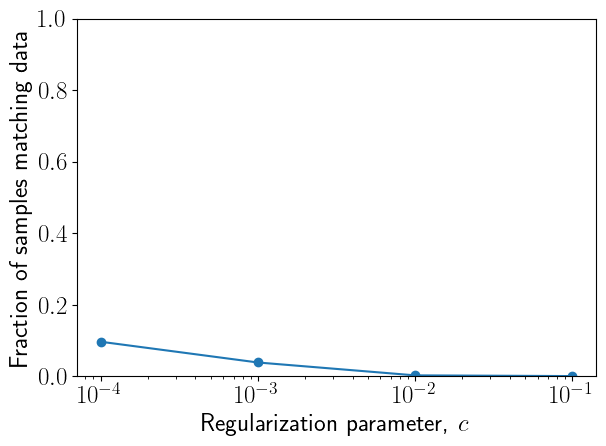

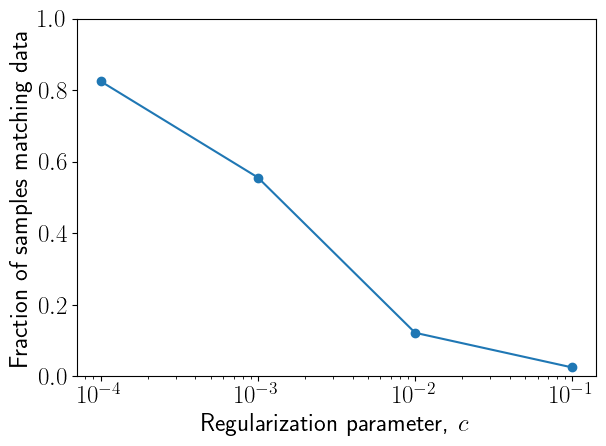

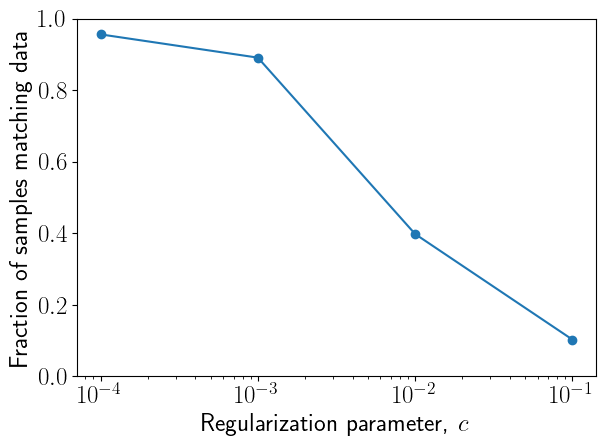

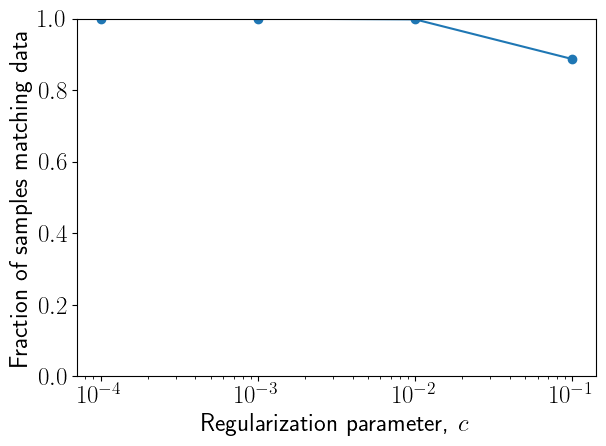

In [17]:
# define tolerances
tol_list = [1e-2, 5e-2, 1e-1, 5e-1]

# define array to store counts
count_data = np.zeros((len(tol_list), len(reg_strength_vect)))

# Define network
score_net = score_edm(device=device, width=width, depth=depth, embed_dim=embed_dim, activation=nn.ReLU)
score_ema = EMA(score_net, beta=0.9999)

for (kk,reg_strength) in enumerate(reg_strength_vect):
    # load model
    score_ema.load_state_dict(torch.load(path_to_save+'regstrength'+str(reg_strength)+'_checkpoint_'+str(epoch)+'.pth')[1])
    # integrate model
    samples_t, samples_x = schedule.ODEsampler(score_ema, latents, T0=1.0, T1=0.)
    # extract final samples
    lat_shape = [batch_size, 2, len(samples_t)]
    res_loc = torch.tensor(samples_x, device=latents.device, dtype=torch.float32).reshape(lat_shape)
    final_samples = res_loc[:,:,-1]
    # check how close each point is to a data point
    for (j,tolerance) in enumerate(tol_list):
        count = 0
        for i in range(batch_size):
            dist = torch.sqrt(torch.sum((final_samples[i,:] - torch.tensor(data, dtype=torch.float32))**2, axis=1))
            if torch.min(dist) < tolerance:
                count += 1
        count_data[j,kk] = count/batch_size

for (j,tolerance) in enumerate(tol_list):
    plt.figure()
    plt.semilogx(reg_strength_vect, count_data[j,:], '-o')
    plt.xlabel(r'Regularization parameter, $c$')
    plt.ylabel(r'Fraction of samples matching data')
    plt.ylim(0,1)
    plt.tight_layout()
    plt.savefig(figures_path+'reg_tol'+str(tolerance)+'.pdf')

## Plot score functions

/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_29598/1305876948.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gmm_train = GMM_score(torch.tensor(data, dtype=torch.float32), schedule.marginal_prob_mean, schedule.marginal_prob_std)


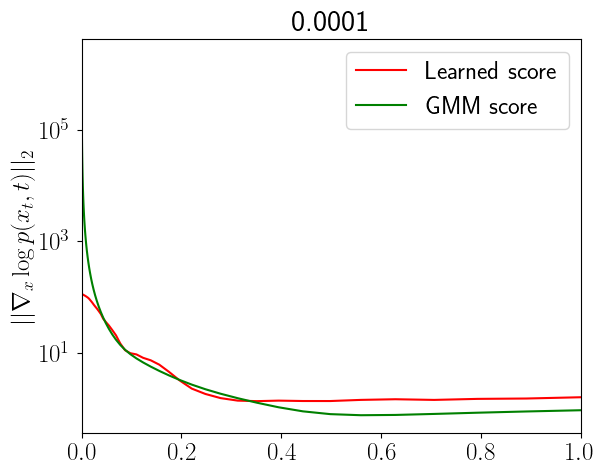

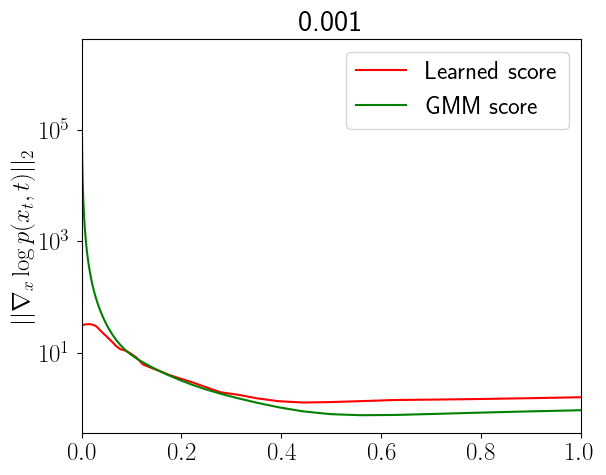

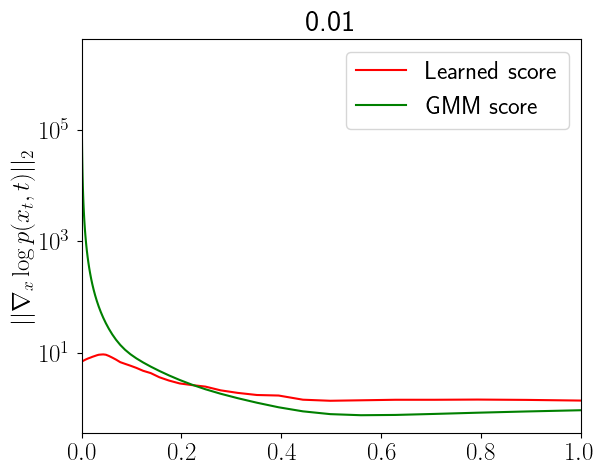

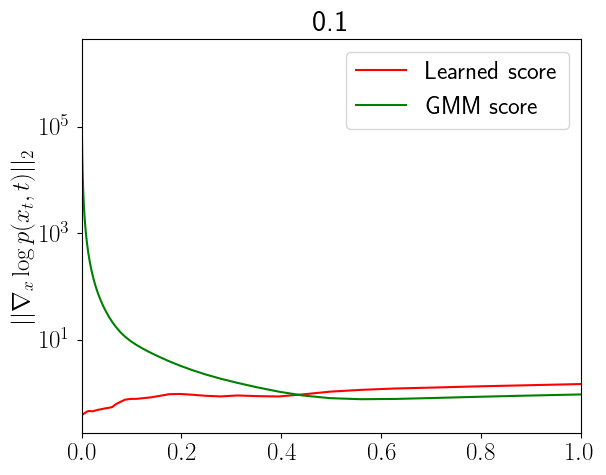

In [14]:
# define plotting location
idx = 0
x_pt_ = data[idx,:].reshape(1,2)
x_pt = x_pt_ + 0.1*torch.randn_like(x_pt_)
t_pts = 10**np.linspace(-5,0,100)
t_pts = torch.tensor(t_pts, device=device, dtype=torch.float32)
t_pts = torch.cat([torch.tensor([0.0], device=device, dtype=torch.float32),t_pts])
t_pts = t_pts[:,None]
x_pt2 = x_pt.repeat(t_pts.shape[0],1).to(device)

# Define network
score_net = score_edm(device=device, width=width, depth=depth, embed_dim=embed_dim, activation=nn.ReLU)
score_ema = EMA(score_net, beta=0.9999)

for (kk,reg_strength) in enumerate(reg_strength_vect):

    # load model
    score_ema.load_state_dict(torch.load(path_to_save+'regstrength'+str(reg_strength)+'_checkpoint_'+str(epoch)+'.pth')[1])

    # evaluate the learned score function and GMM score
    score_learn = score_net(x_pt2, t_pts)
    score_learn_norm = torch.zeros(t_pts.shape[0])
    score_true_norm = torch.zeros(t_pts.shape[0])
    gmm_train = GMM_score(torch.tensor(data, dtype=torch.float32), schedule.marginal_prob_mean, schedule.marginal_prob_std)
    score_gmm_norm = torch.zeros(t_pts.shape[0])

    for i in range(t_pts.shape[0]):
        score_learn_norm[i] = torch.norm(score_learn[i]).detach().cpu() 
        sigma = schedule.marginal_prob_std(t_pts[i]) + 1.0
        score_true_norm[i] = torch.norm( -1*(x_pt.to(device) - x_pt_.to(device))/sigma**2).detach().cpu()
        score_gmm = gmm_train(x_pt.detach().cpu(), t_pts[i].detach().cpu())
        score_gmm_norm[i] = torch.norm(score_gmm).detach().cpu()

    plt.figure()
    plt.plot(t_pts.cpu().numpy(), score_learn_norm.cpu().numpy(), '-r', label='Learned score')
    plt.plot(t_pts.cpu().numpy(), score_gmm_norm.cpu().numpy(), '-g', label='GMM score')
    plt.ylabel(r'$|| \nabla_{x} \log p(x_t, t) ||_2$')
    plt.yscale('log')
    plt.xlim(0,1.0)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.title(reg_strength)
    plt.savefig(figures_path+'regstrength'+str(reg_strength)+'.pdf')